In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('/Users/mads/Documents/Python/kermut/')
from src.experiments.investigate_correlations import load_protein_mpnn_outputs
# from src.data.utils import load_conditional_probs
from src.model.utils import get_fitness_matrix, get_mutation_pair_matrix
from src import COLORS

In [2]:
import torch
# import torch.nn as nn
# from gpytorch.kernels import Kernel
import gpytorch

from src.experiments.investigate_correlations import load_protein_mpnn_outputs
from src import GFP_WT, BLAT_ECOLX_WT, PARD3_10_WT
from src.model.utils import hellinger_distance, Tokenizer

from src.model.kernel import KermutHellingerKernelMulti

In [3]:
def load_conditional_probs(dataset: str, method: str = "esm2"):
    if method == "ProteinMPNN":
        conditional_probs_path = Path(
            "../data",
            "interim",
            dataset,
            "proteinmpnn",
            "conditional_probs_only",
            f"{dataset}.npz",
        )
        if dataset == "GFP":
            drop_index = [0]
        else:
            drop_index = None
        conditional_probs = load_protein_mpnn_outputs(
            conditional_probs_path, as_tensor=True, drop_index=drop_index
        )
    elif method == "esm2":
        conditional_probs_path = Path(
            "data", "interim", dataset, "esm2_masked_probs.pt"
        )
        conditional_probs = torch.load(conditional_probs_path)
    else:
        raise ValueError(f"Unknown method: {method}")

    return conditional_probs

In [18]:
max_mutations = 4
dataset = "PARD3_10" # "GFP"
conditional_probs_method = "ProteinMPNN"

assay_path = Path("../data", "processed", f"{dataset}.tsv")

# Load data
conditional_probs = load_conditional_probs(dataset, conditional_probs_method)
df_all = pd.read_csv(assay_path, sep="\t")

In [19]:
df_sub = df_all[df_all["n_muts"] <= max_mutations]
df_sub.shape

(2947, 6)

In [20]:
df_sub = df_all[df_all["n_muts"] <= max_mutations]
np.random.seed(7312)
idx_train = np.random.choice(len(df_sub), 1000, replace=False)
idx_train = np.insert(idx_train, 0, 0)
idx_test = [idx for idx in range(len(df_sub)) if idx not in idx_train]
idx_test = idx_test[:1000]
df_train = df_sub.iloc[idx_train]
df_test = df_sub.iloc[idx_test]
# df = df.iloc[:1000]
y = df_train["delta_fitness"].values
y = torch.tensor(y, dtype=torch.float32)

tokenizer = Tokenizer()
sequences = df_train["seq"]
tokens = tokenizer(sequences.to_list())
wt_sequence = tokenizer([PARD3_10_WT])[0]
assert len(conditional_probs) == len(wt_sequence)

model_kwargs = {
    "conditional_probs": conditional_probs,
    "wt_sequence": wt_sequence,
    "p_B": 15.0,
    "p_Q": 5.0,
    "theta": 1.0,
    "gamma": 1.0,
    "learnable_transform": False,
    "learnable_hellinger": False,
}

tokens_test = tokenizer(df_test["seq"].to_list())
y_test = df_test["delta_fitness"].values
y_test = torch.tensor(y_test, dtype=torch.float32)


In [21]:
kernel = KermutHellingerKernelMulti(**model_kwargs)

In [24]:
tokens.shape

torch.Size([1001, 93])

In [25]:
out = kernel(tokens)  # IF PROFILING, INDENT
out = out.evaluate()

In [ ]:
out

In [49]:
out.shape

torch.Size([1001, 1001])

In [13]:
# tokens_sub = tokenizer(df_sub["seq"].to_list())
# out_sub = kernel(tokens_sub)  # IF PROFILING, INDENT
# out_sub = out_sub.evaluate()

In [51]:
out.detach().numpy().shape

(1001, 1001)

In [48]:
kernel_samples.shape

(78,)

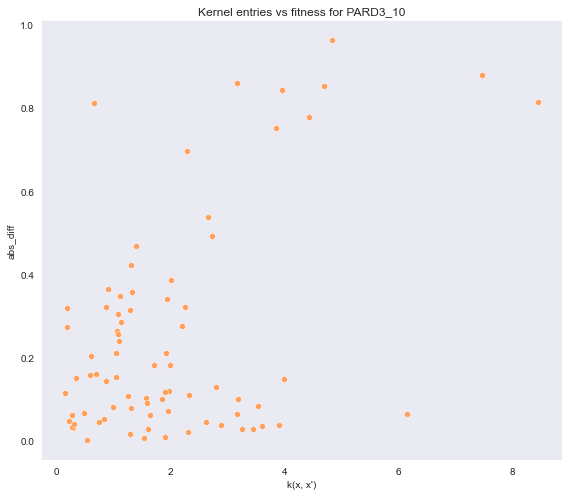

In [43]:
how = "abs_diff"
kernel_samples = out.detach().numpy()
y_vals = get_fitness_matrix(df_train[df_train.n_muts.eq(1)], how=how)
tril_mask = np.tril_indices_from(y_vals, k=-1)
y_vals = y_vals[tril_mask]
kernel_samples = kernel_samples[tril_mask]

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=kernel_samples.flatten(), y=y_vals.flatten(), color=COLORS[4], ax=ax)
ax.set_ylabel(f"{how}")
ax.set_xlabel("k(x, x')")
plt.title(f"Kernel entries vs fitness for {dataset}")
plt.tight_layout()
# plt.savefig(f"figures/{dataset}_fitness_vs_kernel_scatter_Hellinger.png")
plt.show()

In [44]:
print("Compare parts of the plot")
df_kernel = pd.DataFrame({"y": y_vals.flatten(), "kernel": kernel_samples.flatten()})
print(df_kernel[df_kernel.y.gt(2)].shape[0] / df_kernel[df_kernel.y.lt(0.5)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.lt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.lt(0.4)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.gt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.gt(0.4)].shape[0])

Compare parts of the plot
0.0
0.0
0.0


#### Training set 2 or less mutations

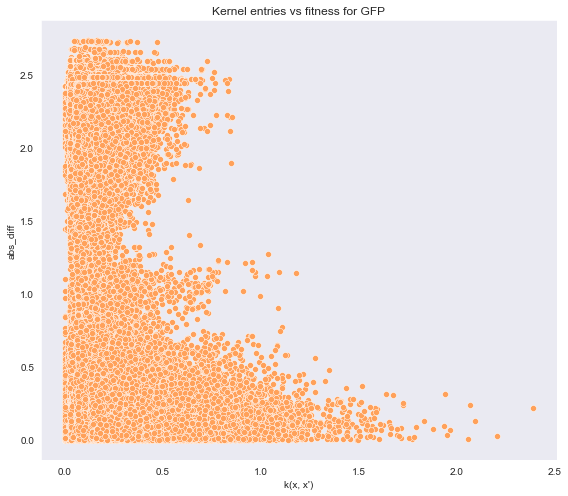

Compare parts of the plot
0.20434201160458143
0.21342097044376934
0.03314059321126459


In [15]:
how = "abs_diff"
kernel_samples = out.detach().numpy()
y_vals = get_fitness_matrix(df_train[df_train.n_muts.le(2)], how=how)
tril_mask = np.tril_indices_from(y_vals, k=-1)
y_vals = y_vals[tril_mask]
kernel_samples = kernel_samples[tril_mask]

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=kernel_samples.flatten(), y=y_vals.flatten(), color=COLORS[4], ax=ax)
ax.set_ylabel(f"{how}")
ax.set_xlabel("k(x, x')")
plt.title(f"Kernel entries vs fitness for {dataset}")
plt.tight_layout()
# plt.savefig(f"figures/{dataset}_fitness_vs_kernel_scatter_Hellinger.png")
plt.show()

print("Compare parts of the plot")
df_kernel = pd.DataFrame({"y": y_vals.flatten(), "kernel": kernel_samples.flatten()})
print(df_kernel[df_kernel.y.gt(2)].shape[0] / df_kernel[df_kernel.y.lt(0.5)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.lt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.lt(0.4)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.gt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.gt(0.4)].shape[0])

#### Test set 2 or less mutations

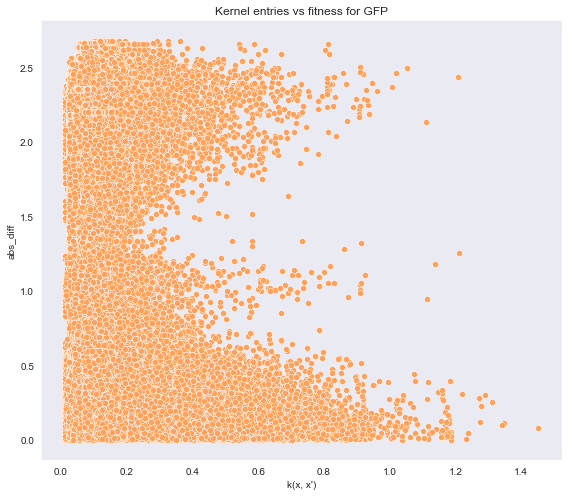

Compare parts of the plot
0.15741734916467467
0.15952680983757114
0.06130641041235859


In [61]:
out_test = kernel(tokens_test)
out_test = out_test.evaluate()

how = "abs_diff"
kernel_samples = out_test.detach().numpy()
y_vals = get_fitness_matrix(df_test[df_test.n_muts.le(2)], how=how)
tril_mask = np.tril_indices_from(y_vals, k=-1)
y_vals = y_vals[tril_mask]
kernel_samples = kernel_samples[tril_mask]

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=kernel_samples.flatten(), y=y_vals.flatten(), color=COLORS[4], ax=ax)
ax.set_ylabel(f"{how}")
ax.set_xlabel("k(x, x')")
plt.title(f"Kernel entries vs fitness for {dataset}")
plt.tight_layout()
# plt.savefig(f"figures/{dataset}_fitness_vs_kernel_scatter_Hellinger.png")
plt.show()

print("Compare parts of the plot")
df_kernel = pd.DataFrame({"y": y_vals.flatten(), "kernel": kernel_samples.flatten()})
print(df_kernel[df_kernel.y.gt(2)].shape[0] / df_kernel[df_kernel.y.lt(0.5)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.lt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.lt(0.4)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.gt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.gt(0.4)].shape[0])

In [81]:
out_test = kernel(tokens_test)
out_test = out_test.evaluate()

how = "abs_diff"
kernel_samples = out_test.detach().numpy()
y_vals = get_fitness_matrix(df_test[df_test.n_muts.le(2)], how=how)
tril_mask = np.tril_indices_from(y_vals, k=-1)

In [82]:
kernel_samples.shape

(1000, 1000)

In [67]:
y_vals.shape

(1000, 1000)

In [70]:
y_vals[tril_mask]


array([0.04946511, 0.16449212, 0.21395723, ..., 0.05235443, 0.0217633 ,
       0.15437305])

In [62]:
y_vals.shape

(499500,)

In [64]:
tril_mask[0].shape

(499500,)

In [33]:
out_test = kernel(tokens_test)
out_test = out_test.evaluate()

In [45]:
mask_tensor = torch.tensor(df_test.n_muts.eq(2).values)

In [72]:
out_test = kernel(tokens_test)
out_test = out_test.evaluate()
out_test = out_test[mask_tensor, mask_tensor]

how = "abs_diff"
kernel_samples = out_test.detach().numpy()
y_vals = get_fitness_matrix(df_test[df_test.n_muts.eq(2)], how=how)
tril_mask = np.tril_indices_from(y_vals, k=-1)

y_vals = y_vals[tril_mask]


In [78]:
y_vals.shape

(392055,)

In [87]:
out_test.shape

torch.Size([1000, 1000])

In [84]:
out_test[mask_tensor, mask_tensor].shape

torch.Size([886])

In [79]:
tril_mask[0].shape

(392055,)

In [76]:
y_vals[tril_mask]

array([0.10872192, 0.02798655, 0.13670847, ..., 0.15556622, 2.20275824,
       0.05235443])

In [90]:
kernel_samples.shape

(1000, 1000)

In [ ]:
kernel_samples = kernel_samples[tril_mask]

In [91]:
out_test_2 = kernel(tokens_test)
out_test_2 = out_test_2.evaluate()


In [92]:
out_test_2b = out_test_2[mask_tensor, mask_tensor]

In [107]:
mask_tensor.sum()

tensor(886)

In [102]:
out_test_2.shape

torch.Size([1000, 1000])

In [108]:
# Get subset of out_test_2 where the rows and columns are those which are True according to mask_tensor. The output should be a square matrix of size mask_tensor.sum() x mask_tensor.sum().
out_test_2b = out_test_2[mask_tensor, mask_tensor]
out_test_2b.shape

torch.Size([886])

In [110]:
out_test_2b.reshape((886, 886))

RuntimeError: shape '[886, 886]' is invalid for input of size 886

In [93]:
out_test_2.shape

torch.Size([1000, 1000])

In [94]:
out_test_2b.shape

torch.Size([886])

In [46]:
out_test = kernel(tokens_test)
out_test = out_test.evaluate()
out_test = out_test[mask_tensor, mask_tensor]

how = "abs_diff"
kernel_samples = out_test.detach().numpy()
y_vals = get_fitness_matrix(df_test[df_test.n_muts.eq(2)], how=how)
tril_mask = np.tril_indices_from(y_vals, k=-1)
y_vals = y_vals[tril_mask]
kernel_samples = kernel_samples[tril_mask]

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=kernel_samples.flatten(), y=y_vals.flatten(), color=COLORS[4], ax=ax)
ax.set_ylabel(f"{how}")
ax.set_xlabel("k(x, x')")
plt.title(f"Kernel entries vs fitness for {dataset}")
plt.tight_layout()
# plt.savefig(f"figures/{dataset}_fitness_vs_kernel_scatter_Hellinger.png")
plt.show()

print("Compare parts of the plot")
df_kernel = pd.DataFrame({"y": y_vals.flatten(), "kernel": kernel_samples.flatten()})
print(df_kernel[df_kernel.y.gt(2)].shape[0] / df_kernel[df_kernel.y.lt(0.5)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.lt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.lt(0.4)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.gt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.gt(0.4)].shape[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Make a GP

In [16]:
training_iter = 5
train_x = tokens
train_y = y

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

In [17]:
model_kwargs = {
    "conditional_probs": conditional_probs,
    "wt_sequence": wt_sequence,
    "p_B": 15.0,
    "p_Q": 5.0,
    "theta": 1.0,
    "gamma": 1.0,
    "learnable_transform": True,
    "learnable_hellinger": True,
}

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, **model_kwargs):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = KermutHellingerKernelMulti(**model_kwargs)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(tokens, y, likelihood, **model_kwargs)

In [18]:
# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

In [19]:
# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = likelihood(model(tokens_test))

In [20]:
preds = observed_pred.mean.detach().numpy()
vals = y_test.numpy()
print(np.corrcoef(preds, vals)[0,1])

0.4146873597718469


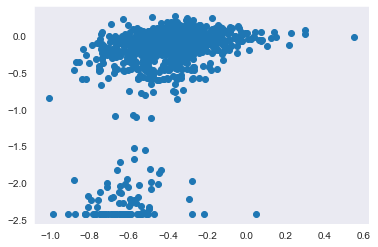

In [21]:
plt.scatter(preds, vals)
plt.show()

In [22]:
np.corrcoef(preds[vals > -1], vals[vals > -1])[0,1]

0.2932129873232656